In [44]:
# Import Important Libraries
from sklearn.linear_model import LogisticRegression # importing Sklearn's logistic regression's module
from sklearn import preprocessing # preprocessing is what we do with the data before we run the learning algorithm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The data is loaded from csv file and loaded into x_train, y_train, x_test, y_test. The split used for training and test data was already provided. The train to test data ratio is 38:62

In [45]:
# loading data 
df_train = pd.read_csv('training.csv',delim_whitespace=False)
df_test = pd.read_csv('testing.csv',delim_whitespace=False)
class_mapping={label:idx for idx,label in enumerate(np.unique(df_train['class']))} # change the class names which are strings to integers
df_train['class']=df_train['class'].map(class_mapping)
class_mapping={label:idx for idx,label in enumerate(np.unique(df_test['class']))}
df_test['class']=df_test['class'].map(class_mapping)
#getting features from the data and saving them into different vectors
x_train_raw = df_train.drop(columns="class")
x_test_raw = df_test.drop(columns="class")
#only saving the values
x_train_raw = x_train_raw.values 
x_test_raw = x_test_raw.values
print(x_train_raw.shape)
print(x_test_raw.shape)

#getting the raw data y_train and y_test
y_train = np.array(df_train['class'])
y_test = np.array(df_test['class'])
print(y_train.shape)
print(y_test.shape)

(198, 27)
(325, 27)
(198,)
(325,)


Three different methods of preprocessing (scaler, normalize and standard scalar) were used to compare their level of accuracy against one another. They are run through the same models. 

In [46]:
#Preprocessing data for Logistic Regression. 
#Standard Scaler
scaler = StandardScaler()
xst_train = scaler.fit(x_train_raw)
xst_test = scaler.fit(x_test_raw)
xst_train = scaler.transform(x_train_raw)
xst_test = scaler.transform(x_test_raw)

#Normalize
xn_train = preprocessing.normalize(x_train_raw)
xn_test = preprocessing.normalize(x_test_raw)

#Scaler
xsc_train = preprocessing.scale(x_train_raw)
xsc_test = preprocessing.scale(x_test_raw)

Using sklearn library to create a logistic regression model using lbfgs solver with l2 panelty. 

In [47]:
def logreg_lbfgs(x_tr,y_tr,x_ts,y_ts,c):
    logreg = LogisticRegression(solver='lbfgs',multi_class='multinomial',dual=False, tol=0.0001, C=c, max_iter=7000,fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
    #Fitting the model 
    model_fit=logreg.fit(x_tr,y_tr)

    #predict
    yhat1 = model_fit.predict(x_tr)
    yhat2 = model_fit.predict(x_ts)
    
    #different accuracy tests
    prec_ts,recall_ts,f1_ts,_= precision_recall_fscore_support(y_ts,yhat2, average='weighted')
    prec_tr,recall_tr,f1_tr,_= precision_recall_fscore_support(y_tr,yhat1, average='weighted')
    
    # Below are some other types of accuracy but f1 score was chosen in our case. 
    # acc_score = accuracy_score(y_tr, yhat1, normalize=True)
    # fit_score = model_fit.score(x_tr,y_tr)
    return f1_ts, f1_tr

In [48]:
#using a for loop and calling logreg with different values of c. 
cp = [ 0.5, 1, 2, 5, 8, 10, 12] 
f1tr_1_sc = []
f1ts_1_sc = []
f1tr_1_n = []
f1ts_1_n = []
f1tr_1_st = []
f1ts_1_st = []

for c in cp:
   
    f1ts_1sc,f1tr_1sc = logreg_lbfgs(xsc_train,y_train,xsc_test,y_test,c)
    f1ts_1n,f1tr_1n = logreg_lbfgs(xn_train,y_train,xn_test,y_test,c)
    f1ts_1st,f1tr_1st = logreg_lbfgs(xst_train,y_train,xst_test,y_test,c)
    
    
    f1tr_1_sc.append(f1tr_1sc)
    f1ts_1_sc.append(f1ts_1sc)
    f1tr_1_st.append(f1tr_1n)
    f1ts_1_st.append(f1ts_1n)
    f1tr_1_n.append(f1tr_1st)
    f1ts_1_n.append(f1ts_1st)
    

Plot F1 score vs c graph for scalar, normalized and standard scaler data for the logistic regression model with l2 panelty

0.7627530082307896
0.8202340599873248
0.8202340599873248


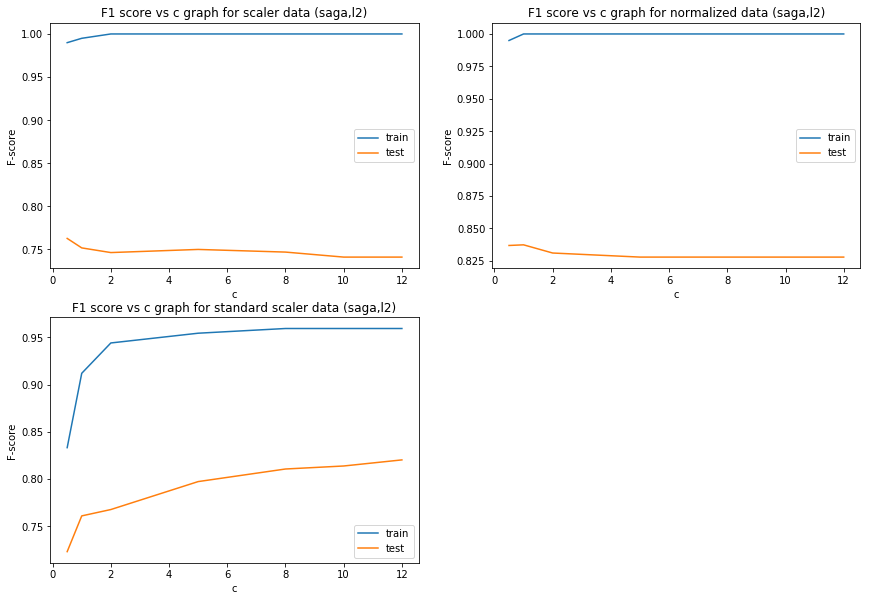

In [49]:
plt.subplots_adjust(right=2, top=2, wspace=None, hspace=None)
plt.subplot(2,2,1)
plt.plot(cp,f1tr_1_sc)
plt.plot(cp,f1ts_1_sc)
print(max(f1ts_1_sc))
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for scaler data (saga,l2)')
plt.gca().legend(('train','test'))
plt.subplot(2,2,2)
plt.plot(cp,f1tr_1_n)
plt.plot(cp,f1ts_1_n)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for normalized data (saga,l2)')
print(max(f1ts_1_st))
plt.gca().legend(('train','test'))
plt.subplot(2,2,3)
plt.plot(cp,f1tr_1_st)
plt.plot(cp,f1ts_1_st)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for standard scaler data (saga,l2)')
print(max(f1ts_1_st))
plt.gca().legend(('train','test'))

Using sklearn library to create a logistic regression model using saga solver with l2 panelty.

In [50]:
#Creating logistical regression models using saga solver (l2 panelty) 
def logreg_saga(x_tr,y_tr,x_ts,y_ts,c):
    logreg_saga = LogisticRegression(penalty='l2',solver='saga',multi_class='multinomial',max_iter=7000,dual=False, tol=0.0001, C=c, fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
    #Fitting the model 
    model_fit=logreg_saga.fit(x_tr,y_tr)

    #predict
    yhat1 = model_fit.predict(x_tr)
    yhat2 = model_fit.predict(x_ts)
   
    #different accuracy tests

    prec_ts,recall_ts,f1_ts,_= precision_recall_fscore_support(y_ts,yhat2, average='weighted')
    prec_tr,recall_tr,f1_tr,_= precision_recall_fscore_support(y_tr,yhat1, average='weighted')
    acc_score = accuracy_score(y_tr, yhat1, normalize=True)
    fit_score = model_fit.score(x_tr,y_tr)
    return f1_ts, f1_tr

In [51]:
#using a for loop and calling logreg with different values of c. 
cp = [ 0.5, 1, 2, 5, 8, 10, 12] 
f1tr_2_sc = []
f1ts_2_sc = []
f1tr_2_n = []
f1ts_2_n = []
f1tr_2_st = []
f1ts_2_st = []

for c in cp:
   
    f1ts_2sc,f1tr_2sc = logreg_saga(xsc_train,y_train,xsc_test,y_test,c)
    f1ts_2n,f1tr_2n = logreg_saga(xn_train,y_train,xn_test,y_test,c)
    f1ts_2st,f1tr_2st = logreg_saga(xst_train,y_train,xst_test,y_test,c)
    
    
    f1tr_2_sc.append(f1tr_2sc)
    f1ts_2_sc.append(f1ts_2sc)
    f1tr_2_st.append(f1tr_2n)
    f1ts_2_st.append(f1ts_2n)
    f1tr_2_n.append(f1tr_2st)
    f1ts_2_n.append(f1ts_2st)
    

Plot F1 score vs c graph for scalar, normalized and standard scaler data for the logistic regression model with saga solver and l2 panelty

0.7654931296633045
0.8202340599873248
0.8202340599873248


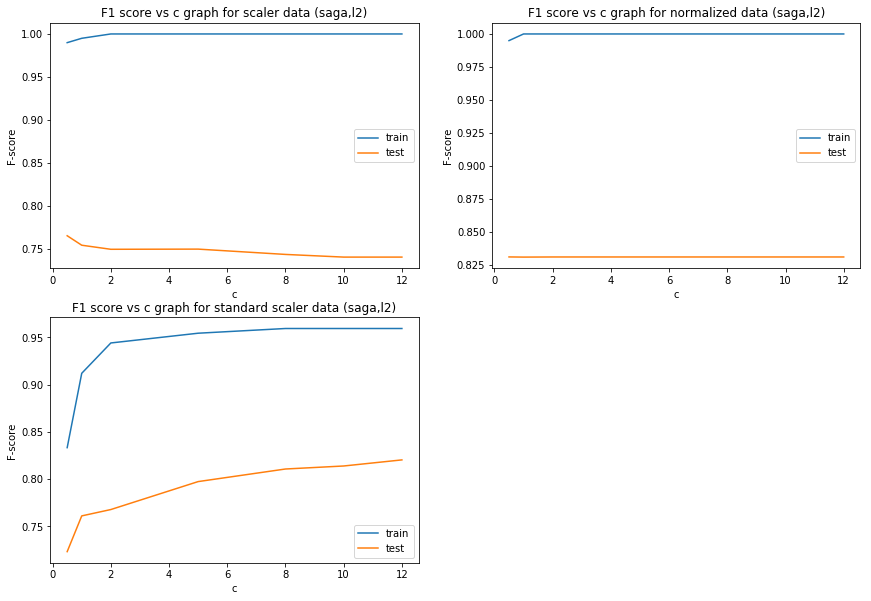

In [52]:
plt.subplots_adjust(right=2, top=2, wspace=None, hspace=None)
plt.subplot(2,2,1)
plt.plot(cp,f1tr_2_sc)
plt.plot(cp,f1ts_2_sc)
print(max(f1ts_2_sc))
plt.xlabel("c")
plt.ylabel("F-score")
plt.gca().legend(('train','test'))
plt.title('F1 score vs c graph for scaler data (saga,l2)')
plt.subplot(2,2,2)
plt.plot(cp,f1tr_2_n)
plt.plot(cp,f1ts_2_n)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for normalized data (saga,l2)')
print(max(f1ts_2_st))
plt.gca().legend(('train','test'))
plt.subplot(2,2,3)
plt.plot(cp,f1tr_2_st)
plt.plot(cp,f1ts_2_st)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for standard scaler data (saga,l2)')
print(max(f1ts_2_st))
plt.gca().legend(('train','test'))

Using sklearn library to create a logistic regression model using saga solver with l1 panelty.

In [53]:
#Creating logistical regression models using saga solver (l1 panelty) 
def logreg_saga2(x_tr,y_tr,x_ts,y_ts,c):
    logreg_saga2 = LogisticRegression(penalty='l1',solver='saga',max_iter=7000,multi_class='multinomial',dual=False, tol=0.0001, C=c, fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
    #Fitting the model 
    model_fit=logreg_saga2.fit(x_tr,y_tr)
    #predict
    yhat1 = model_fit.predict(x_tr)
    yhat2 = model_fit.predict(x_ts)
    #accuracy 
    prec_ts,recall_ts,f1_ts,_= precision_recall_fscore_support(y_ts,yhat2, average='weighted')
    prec_tr,recall_tr,f1_tr,_= precision_recall_fscore_support(y_tr,yhat1, average='weighted')
    acc_score = accuracy_score(y_tr, yhat1, normalize=True)
    fit_score = model_fit.score(x_tr,y_tr)
    return f1_ts, f1_tr

In [54]:
#using a for loop and calling logreg with different values of c. 
#using a for loop and calling logreg with different values of c. 
cp = [ 0.5, 1, 2, 5, 8, 10, 12] 
f1tr_3_sc = []
f1ts_3_sc = []
f1tr_3_n = []
f1ts_3_n = []
f1tr_3_st = []
f1ts_3_st = []

for c in cp:
   
    f1ts_3sc,f1tr_3sc = logreg_saga2(xsc_train,y_train,xsc_test,y_test,c)
    f1ts_3n,f1tr_3n = logreg_saga2(xn_train,y_train,xn_test,y_test,c)
    f1ts_3st,f1tr_3st = logreg_saga2(xst_train,y_train,xst_test,y_test,c)
    
    
    f1tr_3_sc.append(f1tr_3sc)
    f1ts_3_sc.append(f1ts_3sc)
    f1tr_3_st.append(f1tr_3n)
    f1ts_3_st.append(f1ts_3n)
    f1tr_3_n.append(f1tr_3st)
    f1ts_3_n.append(f1ts_3st)
    

Plot F1 score vs c graph for scalar, normalized and standard scaler data for the logistic regression model with saga solver and l1 panelty

0.7823963093653613
0.8294672839162093
0.8294672839162093


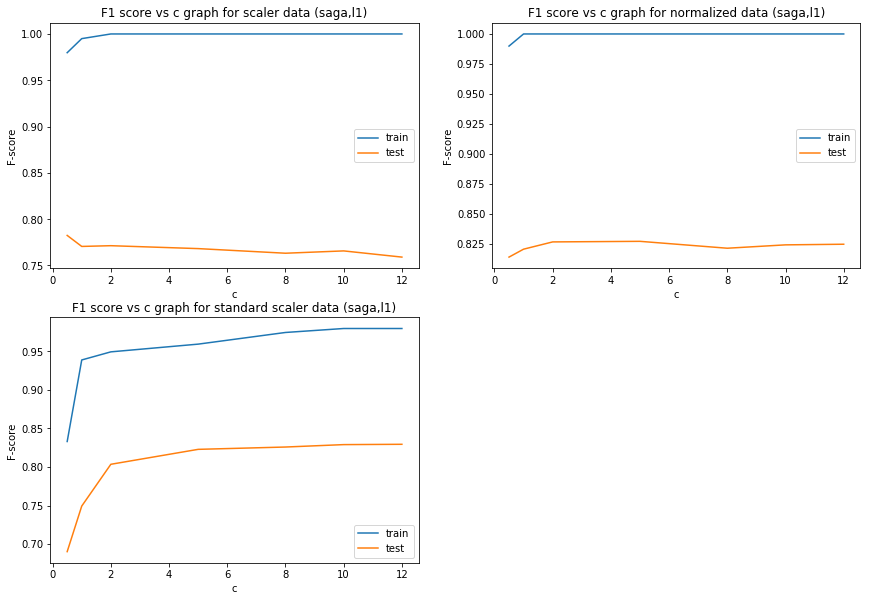

In [55]:
plt.subplots_adjust(right=2, top=2, wspace=None, hspace=None)
plt.subplot(2,2,1)
plt.plot(cp,f1tr_3_sc)
plt.plot(cp,f1ts_3_sc)
print(max(f1ts_3_sc))
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for scaler data (saga,l1)')
plt.gca().legend(('train','test'))
plt.subplot(2,2,2)
plt.plot(cp,f1tr_3_n)
plt.plot(cp,f1ts_3_n)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for normalized data (saga,l1)')
print(max(f1ts_3_st))
plt.gca().legend(('train','test'))
plt.subplot(2,2,3)
plt.plot(cp,f1tr_3_st)
plt.plot(cp,f1ts_3_st)
plt.xlabel("c")
plt.ylabel("F-score")
plt.title('F1 score vs c graph for standard scaler data (saga,l1)')
print(max(f1ts_3_st))
plt.gca().legend(('train','test'))

Cross Validation on data that was Scaler

In [56]:
#Cross Validation # Scaler Preprocessing of the data 
def cross_valsc(x_train,y_train,nfold):
    from sklearn.model_selection import KFold
    from sklearn.metrics import confusion_matrix
    kf = KFold(n_splits=nfold)
    conf_sum1 = 0;
    conf_sum2 = 0;
    conf_sum3 = 0;
    f11 = []
    f12 = []
    f13= []

    for train, test in kf.split(xsc_train):            
    # Get training and test data
        Xtr = xsc_train[train,:]
        ytr = y_train[train]
        Xts = xsc_train[test,:]
        yts = y_train[test]

        # Fit a model
        
        logreg_main1 = LogisticRegression(penalty='l2',solver='lbfgs',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=3, fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
        logreg_main2 = LogisticRegression(penalty='l2',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=3, fit_intercept=True, intercept_scaling=1) #saga handles l2 penalty (ridge regularization)
        logreg_main3 = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=3, fit_intercept=True, intercept_scaling=1) #saga handles l1 penalty (lasso regularization)
        #Fitting the model 
        logreg_main1.fit(Xtr, ytr)
        logreg_main2.fit(Xtr, ytr)
        logreg_main3.fit(Xtr, ytr)
        yhat1 = logreg_main1.predict(Xts)
        yhat2 = logreg_main2.predict(Xts)
        yhat3 = logreg_main3.predict(Xts)

        # Measuring performance
        conf1 = confusion_matrix(yts,yhat1)
        conf_sum1 = np.add (conf1,conf_sum1)
        prec_11,recall_11,f1_11,_= precision_recall_fscore_support(yts,yhat1) 
        f11.append(f1_11)
    
        conf2 = confusion_matrix(yts,yhat2)
        conf_sum2 = np.add (conf2,conf_sum2)
        prec_12,recall_12,f1_12,_= precision_recall_fscore_support(yts,yhat2) 
        f12.append(f1_12)
        
        conf3 = confusion_matrix(yts,yhat3)
        conf_sum3 = np.add (conf3,conf_sum3)
        prec_13,recall_13,f1_13,_= precision_recall_fscore_support(yts,yhat3)
        f13.append(f1_13)
        
    mean_f12 = np.mean(f12)
    mean_f11 = np.mean(f11)
    mean_f13 = np.mean(f13)
    print(conf_sum1)
    print(conf_sum2)
    print(conf_sum3)
    return mean_f12,mean_f11, mean_f13

In [57]:
mean_f12,mean_f11,mean_f13=cross_valsc(xsc_train,y_train,7)
print(mean_f11)
print(mean_f12)
print(mean_f13)

#NOTE: THIS WARNING CAN BE REMOVED BY CHANGING THE NUMBER OF ITERATIONS. HOWEVER, MORE NUMBER OF MAX ITERATIONS DECREASE 
#EFFICIENCY. 

[[52  0  1  1]
 [ 0 48  0  0]
 [ 1  0 35  1]
 [ 0  1  1 57]]
[[52  0  1  1]
 [ 0 48  0  0]
 [ 1  0 35  1]
 [ 0  1  1 57]]
[[52  0  1  1]
 [ 0 47  0  1]
 [ 2  1 33  1]
 [ 0  1  1 57]]
0.9679377060517539
0.9679377060517539
0.9454745541243162


Cross Validaiton on Data that was normalized

In [60]:
#Cross Validation #Normalized Preprocessing of the data 
def cross_valn(x_train,y_train,nfold):
    from sklearn.model_selection import KFold
    from sklearn.metrics import confusion_matrix
    kf = KFold(n_splits=nfold)
    conf_sum1 = 0;
    conf_sum2 = 0;
    conf_sum3 = 0;
    f11 = []
    f12 = []
    f13= []

    for train, test in kf.split(xsc_train):            
    # Get training and test data
        Xtr = xn_train[train,:]
        ytr = y_train[train]
        Xts = xn_train[test,:]
        yts = y_train[test]

        # Fit a model
        
        logreg_main1 = LogisticRegression(penalty='l2',solver='lbfgs',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=2, fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
        logreg_main2 = LogisticRegression(penalty='l2',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=2, fit_intercept=True, intercept_scaling=1) #saga handles l2 penalty (ridge regularization)
        logreg_main3 = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=2, fit_intercept=True, intercept_scaling=1) #saga handles l1 penalty (lasso regularization)
        #Fitting the model 
        logreg_main1.fit(Xtr, ytr)
        logreg_main2.fit(Xtr, ytr)
        logreg_main3.fit(Xtr, ytr)
        yhat1 = logreg_main1.predict(Xts)
        yhat2 = logreg_main2.predict(Xts)
        yhat3 = logreg_main3.predict(Xts)

        # Measuring performance
        conf1 = confusion_matrix(yts,yhat1)
        conf_sum1 = np.add (conf1,conf_sum1)
        prec_11,recall_11,f1_11,_= precision_recall_fscore_support(yts,yhat1) 
        f11.append(f1_11)
    
        conf2 = confusion_matrix(yts,yhat2)
        conf_sum2 = np.add (conf2,conf_sum2)
        prec_12,recall_12,f1_12,_= precision_recall_fscore_support(yts,yhat2)
        f12.append(f1_12)
        
        conf3 = confusion_matrix(yts,yhat3)
        conf_sum3 = np.add (conf3,conf_sum3)
        prec_13,recall_13,f1_13,_= precision_recall_fscore_support(yts,yhat3) 
        f13.append(f1_13)
        
    mean_f12 = np.mean(f12)
    mean_f11 = np.mean(f11)
    mean_f13 = np.mean(f13)
    print(conf_sum1)
    print(conf_sum2)
    print(conf_sum3)
    return mean_f12,mean_f11, mean_f13

In [61]:
mean_f12,mean_f11,mean_f13=cross_valn(xn_train,y_train,7)
print(mean_f11)
print(mean_f12)
print(mean_f13)

#NOTE: THIS WARNING CAN BE REMOVED BY CHANGING THE NUMBER OF ITERATIONS. HOWEVER, MORE NUMBER OF MAX ITERATIONS DECREASE 
#EFFICIENCY. 

[[51  0  1  2]
 [ 0 48  0  0]
 [ 7  2 28  0]
 [ 1  3  0 55]]
[[51  0  1  2]
 [ 0 48  0  0]
 [ 7  2 28  0]
 [ 1  3  0 55]]
[[51  0  2  1]
 [ 0 47  0  1]
 [ 3  1 33  0]
 [ 1  3  0 55]]
0.9102469401367508
0.9102469401367508
0.9159210660624248


Cross Validation on scaler standard data

In [19]:
# #Cross Validation # Scaler Preprocessing of the data 
# def cross_valst(x_train,y_train,nfold):
#     from sklearn.model_selection import KFold
#     from sklearn.metrics import confusion_matrix
#     kf = KFold(n_splits=nfold)
#     conf_sum1 = 0;
#     conf_sum2 = 0;
#     conf_sum3 = 0;
#     f11 = []
#     f12 = []
#     f13= []

#     for train, test in kf.split(xsc_train):            
#     # Get training and test data
#         Xtr = xst_train[train,:]
#         ytr = y_train[train]
#         Xts = xst_train[test,:]
#         yts = y_train[test]

#         # Fit a model
        
#         logreg_main1 = LogisticRegression(penalty='l2',solver='lbfgs',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=10, fit_intercept=True, intercept_scaling=1) #lbfgs handles l2 penalty (ridge regularization)
#         logreg_main2 = LogisticRegression(penalty='l2',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=70, fit_intercept=True, intercept_scaling=1) #saga handles l2 penalty (ridge regularization)
#         logreg_main3 = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',dual=False, tol=0.0001,max_iter=7000, C=60, fit_intercept=True, intercept_scaling=1) #saga handles l1 penalty (lasso regularization)
#         #Fitting the model 
#         logreg_main1.fit(Xtr, ytr)
#         logreg_main2.fit(Xtr, ytr)
#         logreg_main3.fit(Xtr, ytr)
#         yhat1 = logreg_main1.predict(Xts)
#         yhat2 = logreg_main2.predict(Xts)
#         yhat3 = logreg_main3.predict(Xts)

#         # Measuring performance
#         conf1 = confusion_matrix(yts,yhat1)
#         conf_sum1 = np.add (conf1,conf_sum1)
#         prec_11,recall_11,f1_11,_= precision_recall_fscore_support(yts,yhat1) 
#         f11.append(f1_11)
    
#         conf2 = confusion_matrix(yts,yhat2)
#         conf_sum2 = np.add (conf2,conf_sum2)
#         prec_12,recall_12,f1_12,_= precision_recall_fscore_support(yts,yhat2) 
#         f12.append(f1_12)
        
#         conf3 = confusion_matrix(yts,yhat3)
#         conf_sum3 = np.add (conf3,conf_sum3)
#         prec_13,recall_13,f1_13,_= precision_recall_fscore_support(yts,yhat3) 
#         f13.append(f1_13)
        
#     mean_f12 = np.mean(f12)
#     mean_f11 = np.mean(f11)
#     mean_f13 = np.mean(f13)
#     print(conf_sum1)
#     print(conf_sum2)
#     print(conf_sum3)
#     return mean_f12,mean_f11, mean_f13

In [20]:
# mean_f12,mean_f11,mean_f13=cross_valst(xst_train,y_train,7)
# print(mean_f11)
# print(mean_f12)
# print(mean_f13)

# #NOTE: THIS WARNING CAN BE REMOVED BY CHANGING THE NUMBER OF ITERATIONS. HOWEVER, MORE NUMBER OF MAX ITERATIONS DECREASE 
# #EFFICIENCY.

[[52  0  1  1]
 [ 0 47  0  1]
 [ 1  0 35  1]
 [ 0  1  1 57]]
[[52  0  1  1]
 [ 0 47  0  1]
 [ 1  0 35  1]
 [ 0  1  1 57]]
[[52  0  1  1]
 [ 0 47  0  1]
 [ 1  0 35  1]
 [ 0  0  1 58]]
0.9640410280171449
0.9640410280171449
0.9701101223215333


In [22]:
poly = PolynomialFeatures(degree=2) #ADAPTED FROM HOMEWORK 5
xsc_transformed_train = poly.fit_transform(xsc_train)
xsc_transformed_test = poly.fit_transform(xsc_test)
xn_transformed_train = poly.fit_transform(xn_train)
xn_transformed_test = poly.fit_transform(xn_test)
xst_transformed_train = poly.fit_transform(xst_train)
xst_transformed_test = poly.fit_transform(xst_test)
print(xsc_transformed_test.shape)


(325, 406)


Finding the test and training accuracy using polynomial features preprocessing on scalar data 

In [23]:
f1ts1 = []
f1ts2= []
f1ts3 = []

for c in cp:
    f1_ts1, f1_tr1 = logreg_lbfgs(xsc_transformed_train,y_train,xsc_transformed_test,y_test,c)
    f1_ts2, f1_tr2= logreg_saga(xsc_transformed_train,y_train,xsc_transformed_test,y_test,c)
    f1_ts3, f1_tr3 = logreg_saga2(xsc_transformed_train,y_train,xsc_transformed_test,y_test,c)

    f1ts1.append(f1_ts1)
    f1ts2.append(f1_ts2)
    f1ts3.append(f1_ts3)

print(max(f1ts1))
print(max(f1ts2))
print(max(f1ts3))


0.752147008815508
0.7732554246754545
0.7877403281798886


Finding the test and training accuracy using polynomial features preprocessing on normalize data 

In [24]:
f1ts1 = []
f1ts2= []
f1ts3 = []

for c in cp:
    f1_ts1, f1_tr1 = logreg_lbfgs(xn_transformed_train,y_train,xn_transformed_test,y_test,c)
    f1_ts2, f1_tr2= logreg_saga(xn_transformed_train,y_train,xn_transformed_test,y_test,c)
    f1_ts3, f1_tr3 = logreg_saga2(xn_transformed_train,y_train,xn_transformed_test,y_test,c)

    f1ts1.append(f1_ts1)
    f1ts2.append(f1_ts2)
    f1ts3.append(f1_ts3)

print(max(f1ts1))
print(max(f1ts2))
print(max(f1ts3))

0.8297123316664207
0.8297123316664207
0.8322473608464275


Finding the test and training accuracy using polynomial features preprocessing on standard scaler data

In [203]:
f1ts1 = []
f1ts2= []
f1ts3 = []

for c in cp:
    f1_ts1, f1_tr1 = logreg_lbfgs(xst_transformed_train,y_train,xst_transformed_test,y_test,c)
    f1_ts2, f1_tr2= logreg_saga(xst_transformed_train,y_train,xst_transformed_test,y_test,c)
    f1_ts3, f1_tr3 = logreg_saga2(xst_transformed_train,y_train,xst_transformed_test,y_test,c)

    f1ts1.append(f1_ts1)
    f1ts2.append(f1_ts2)
    f1ts3.append(f1_ts3)

print(max(f1ts1))
print(max(f1ts2))
print(max(f1ts3))


0.8040262893843795
0.8298684015837628
0.850283496594492
